In [91]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 15,                   # Set font size to 11pt
    'axes.labelsize': 15,               # -> axis labels
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'text.usetex': False,
    'pgf.rcfonts': False,
})
plt.tight_layout(rect=[0, 0.03, 1, 0.85])

<Figure size 640x480 with 0 Axes>

In [92]:
BASE_DIR = Path("data/eval_parallelized/")
BASE_DIR = Path("/Users/roy/data/ripple_bench/parallelized")
BASE_RESULTS = {
    "llama": BASE_DIR / "Llama-3-8b-Instruct_ripple_results.csv",
    "zephyr": BASE_DIR / "zephyr-7b-beta_ripple_results.csv",
}
PLOT_DIR = Path("plots/")
PLOT_DIR.mkdir(parents=True, exist_ok=True)
from datetime import datetime

## Fact 1: Questions closer to WMDP are easier

Here we deduplicate the dataset, and only consider minimum distance value per unique question. I.e. we only count one repetition per Ripple Bench question, and we take one with the smallest distance.

This has an interesting impact on the accuracy: base models have higher accuracy on WMDP-adjacent questions. This effect is heavily diluted when these same questions are repeated 20+ times with various distance values.

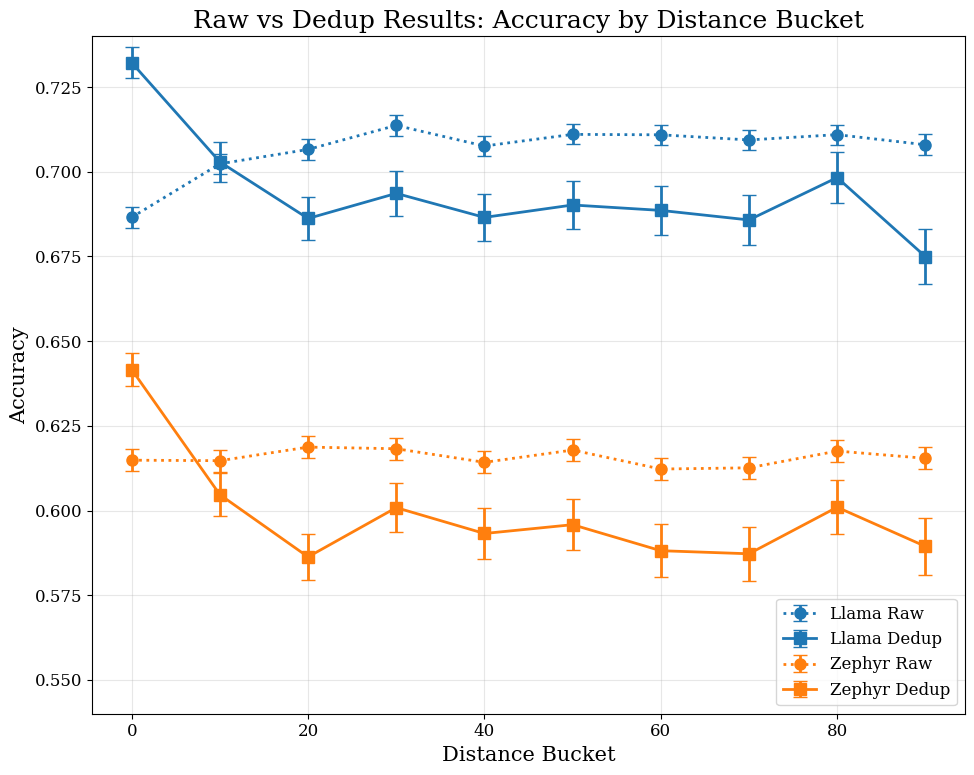

In [93]:
# Initialize the plot
plt.figure(figsize=(10, 8))

# Define colors for each model
colors = ['C0', 'C1']
bucket_size = 10

# Process both models
for i, (model_name, file_path) in enumerate(BASE_RESULTS.items()):
    df = pd.read_csv(file_path)
    df = df[df["distance"] < 100]
    df["distance_bucket"] = (df["distance"] // bucket_size) * bucket_size

    # Raw results
    raw_results = df.groupby("distance_bucket")["is_correct"].agg(["mean", "std"])
    raw_results["sem"] = raw_results["std"] / np.sqrt(df.groupby("distance_bucket").size())

    # Dedup results
    df_dedup = df.groupby("question")[["is_correct", "distance_bucket"]].agg(
        ["max", "min", "sum", "count", "mean"]
    )
    dedup_results = df_dedup.groupby(df_dedup["distance_bucket"]["min"]).agg(["mean", "std"])["is_correct"]["mean"]
    dedup_results["sem"] = dedup_results["std"] / np.sqrt(df_dedup["distance_bucket"].groupby("min").size())

    # Plot raw results with dashed line
    plt.errorbar(raw_results.index, raw_results["mean"], yerr=raw_results["sem"], 
                 marker='o', linewidth=2, markersize=8, capsize=5, linestyle=':',
                 color=colors[i], label=f'{model_name.title()} Raw')

    # Plot dedup results with solid line
    plt.errorbar(dedup_results.index, dedup_results["mean"], yerr=dedup_results["sem"], 
                 marker='s', linewidth=2, markersize=8, capsize=5, linestyle='-',
                 color=colors[i], label=f'{model_name.title()} Dedup')

plt.xlabel('Distance Bucket')
plt.ylabel('Accuracy')
plt.title('Raw vs Dedup Results: Accuracy by Distance Bucket')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0.54, 0.74)

plt.tight_layout()
plt.show()


## Detour: how does it happen?

Why does deduplication has such an effect on per-distance accuracy?

Let's look at accuracy per number of repetitions. We see that questions repeated 10-50 times have higher than average accuracy (top graph). These question account for about 50% of all questions in deduplicated ripple bench (bottom graph).

Questions that are closer to the original WDMP topics have a higher chance of being repeated (statistically, because we start with them), and are generally easier (for whatever reason, data quality could be one. In fact I attribute drop at 50+ repetitions to data quality, I'm pretty sure it's those weird documents that are close to everything).

Putting this together leads to a pretty straight accuracy line on raw dataset, while deduplicated shows drop in the base accuracy for higher distance values

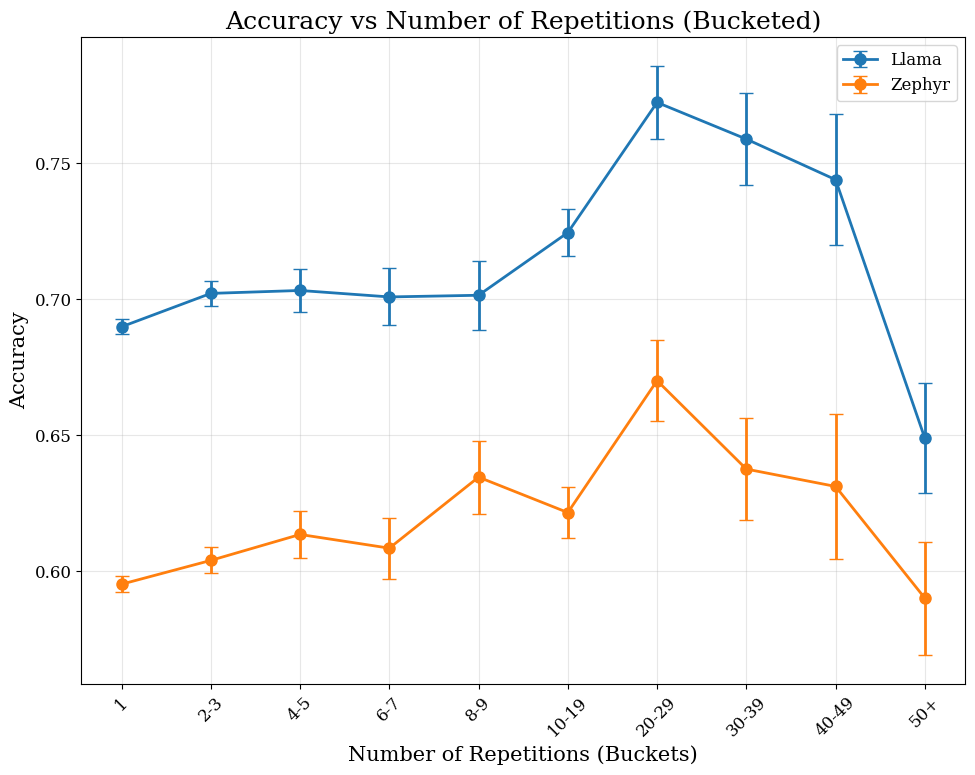

In [94]:
# Create buckets for number of repetitions
def create_repetition_buckets(count):
    if count == 1:
        return '1'
    elif count < 10:
        # Groups of 2 for 2-9
        start = ((count - 2) // 2) * 2 + 2
        end = start + 1
        return f'{start}-{end}'
    elif count < 50:
        # Groups of 10 for 10-99
        start = (count // 10) * 10
        end = start + 9
        return f'{start}-{end}'
    else:
        # All together for 100+
        return '50+'

plt.figure(figsize=(10, 8))
colors = ['C0', 'C1']

for i, (model_name, file_path) in enumerate(BASE_RESULTS.items()):
    df = pd.read_csv(file_path)
    df = df[df["distance"] < 100]

    df = df.groupby('question')['is_correct'].agg(['max', 'min', 'sum', 'count'])
    df['repetition_bucket'] = df['count'].apply(create_repetition_buckets)

    bucket_order = ['1', '2-3', '4-5', '6-7', '8-9', '10-19', '20-29', '30-39', '40-49', '50+']

    repetition_stats = df.groupby('repetition_bucket')['max'].agg(['mean', 'count', 'std'])

    existing_buckets = [bucket for bucket in bucket_order if bucket in repetition_stats.index]
    repetition_stats = repetition_stats.reindex(existing_buckets)
    bucket_accuracy = repetition_stats['mean']
    bucket_stderr = repetition_stats['std'] / np.sqrt(repetition_stats['count'])

    # Plot accuracy vs repetition buckets with error bars
    x_positions = range(len(bucket_accuracy))
    plt.errorbar(x_positions, bucket_accuracy.values, yerr=bucket_stderr.values,
                marker='o', linewidth=2, markersize=8, capsize=5, label=model_name.title())

plt.xlabel('Number of Repetitions (Buckets)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Repetitions (Bucketed)')
plt.xticks(x_positions, bucket_accuracy.index, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


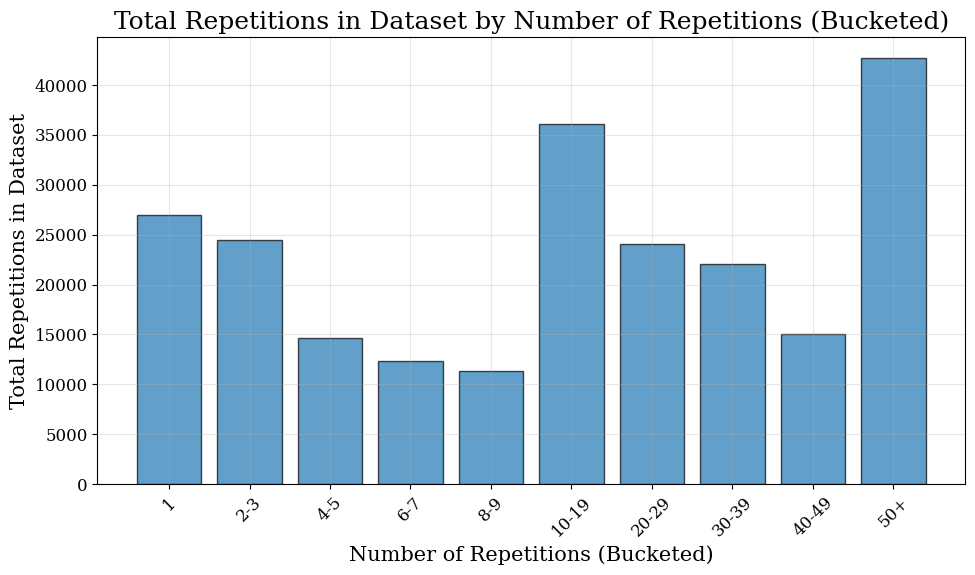

Total number of data points: 229648


In [95]:
df = pd.read_csv(BASE_RESULTS["llama"])
df = df.groupby('question')['is_correct'].agg(['max', 'min', 'sum', 'count'])


# Add bucket column
df['repetition_bucket'] = df['count'].apply(create_repetition_buckets)

# Calculate total repetitions by bucket
total_reps_by_bucket = df.groupby('repetition_bucket')['count'].sum().reindex(bucket_order)

# Plot histogram showing total repetitions by bucket
plt.figure(figsize=(10, 6))
plt.bar(total_reps_by_bucket.index, total_reps_by_bucket.values, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Repetitions (Bucketed)')
plt.ylabel('Total Repetitions in Dataset')
plt.title('Total Repetitions in Dataset by Number of Repetitions (Bucketed)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total number of data points: {total_reps_by_bucket.sum()}")


## Unlearning

Now, let's look at unlearning results.

In [96]:
UNLEARNING_RESULTS = {
    "llama": {
        "elm": BASE_DIR / "llama-3-8b-instruct-elm-ckpt7_ripple_results.csv",
        "graddiff": BASE_DIR / "llama-3-8b-instruct-graddiff-ckpt8_ripple_results.csv",
        "pbj": BASE_DIR / "llama-3-8b-instruct-pbj-ckpt6_ripple_results.csv",
        "repnoise": BASE_DIR / "llama-3-8b-instruct-repnoise-ckpt6_ripple_results.csv",
        "rmu": BASE_DIR / "llama-3-8b-instruct-rmu-ckpt6_ripple_results.csv",
        "rmu_lat": BASE_DIR / "llama-3-8b-instruct-rmu-lat-ckpt7_ripple_results.csv",
        "rr": BASE_DIR / "llama-3-8b-instruct-rr-ckpt8_ripple_results.csv",
        "tar": BASE_DIR / "llama-3-8b-instruct-tar-ckpt8_ripple_results.csv",
    },

    "zephyr": {
        "elm": BASE_DIR / "zephyr-7b-elm_ripple_results.csv",
        # "rmu": "data/eval_aug_12/zephyr_rmu_aug_12.csv",

    }
}

In [97]:
def load_df(path, bucket_size=10):
    df = pd.read_csv(path)
    df = df[df["distance"] < 100]
    df["distance_bucket"] = (df["distance"] // bucket_size) * bucket_size

    return df

def get_dedup_results(df):
    df_dedup = df.groupby("question")[["is_correct", "distance_bucket"]].agg(
        ["max", "min", "sum", "count", "mean"]
    )
    results = df_dedup.groupby(df_dedup["distance_bucket"]["min"]).agg(["mean", "std"])["is_correct"]["mean"]
    results["sem"] = results["std"] / np.sqrt(df_dedup["distance_bucket"].groupby("min").size())
    return results

def get_legacy_results(df):
    raw_results = df.groupby("distance_bucket")["is_correct"].agg(["mean", "std"])
    raw_results["sem"] = raw_results["std"] / np.sqrt(df.groupby("distance_bucket").size())
    return raw_results

In [98]:
def draw(results_fn):
    # Initialize the plot with 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    i=0
    for model in UNLEARNING_RESULTS:
        base_df = load_df(BASE_RESULTS[model])
        base_results = results_fn(base_df)

        for method in UNLEARNING_RESULTS[model]:
            ax = axes[i]
            i+=1
            
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Plot base results
            ax.errorbar(
                base_results.index,
                base_results["mean"],
                yerr=base_results["sem"],
                marker="o",
                linewidth=2,
                markersize=6,
                capsize=3,
                label="Base",
            )
            
            # Plot unlearning results for this method
            ax.errorbar(
                unlearn_results_method.index,
                unlearn_results_method["mean"],
                yerr=unlearn_results_method["sem"],
                marker="s",
                linewidth=2,
                markersize=6,
                capsize=3,
                label=f"Unlearn",
            )
            
            ax.set_xlabel("Distance Bucket")
            ax.set_ylabel("Accuracy")
            ax.set_title(f"{model} ({method.title()})")
            if i == 1:
                ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            if model == "llama":
                ax.set_ylim(0.4, 0.75)

    plt.tight_layout()
    plt.show()


# Raw accuracy

First, let's look at raw accuracy per distance bucket: comparing base (blue) vs unlearned (orange).

With deduplicated questions, there's a clear distance effect with distance values up to 20: while base accuracy goes slightly down (because questions are easier), unlearned accuracy goes up (because ripple effects)

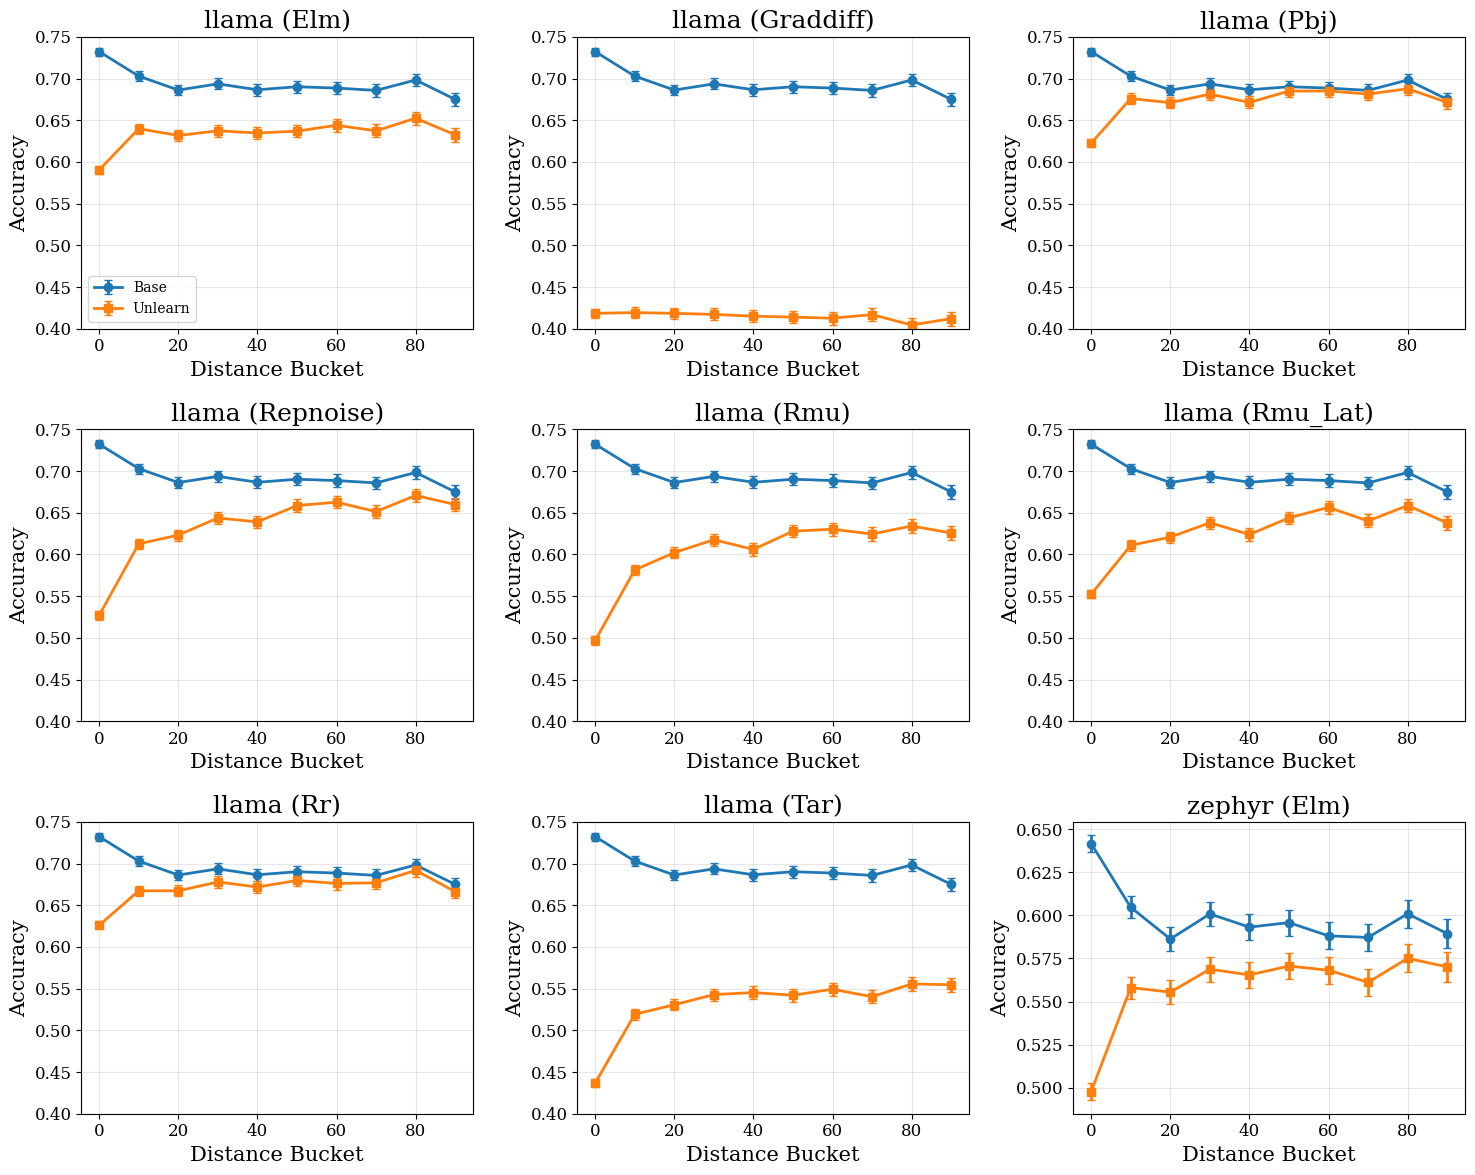

In [99]:
draw(results_fn=get_dedup_results)

Looking at the same data, but before deduplication - the effect is not as pronounced, but it's still there. The effect is dampened mostly because questions that are really close to WMDP are also repeated across the whole distance range.

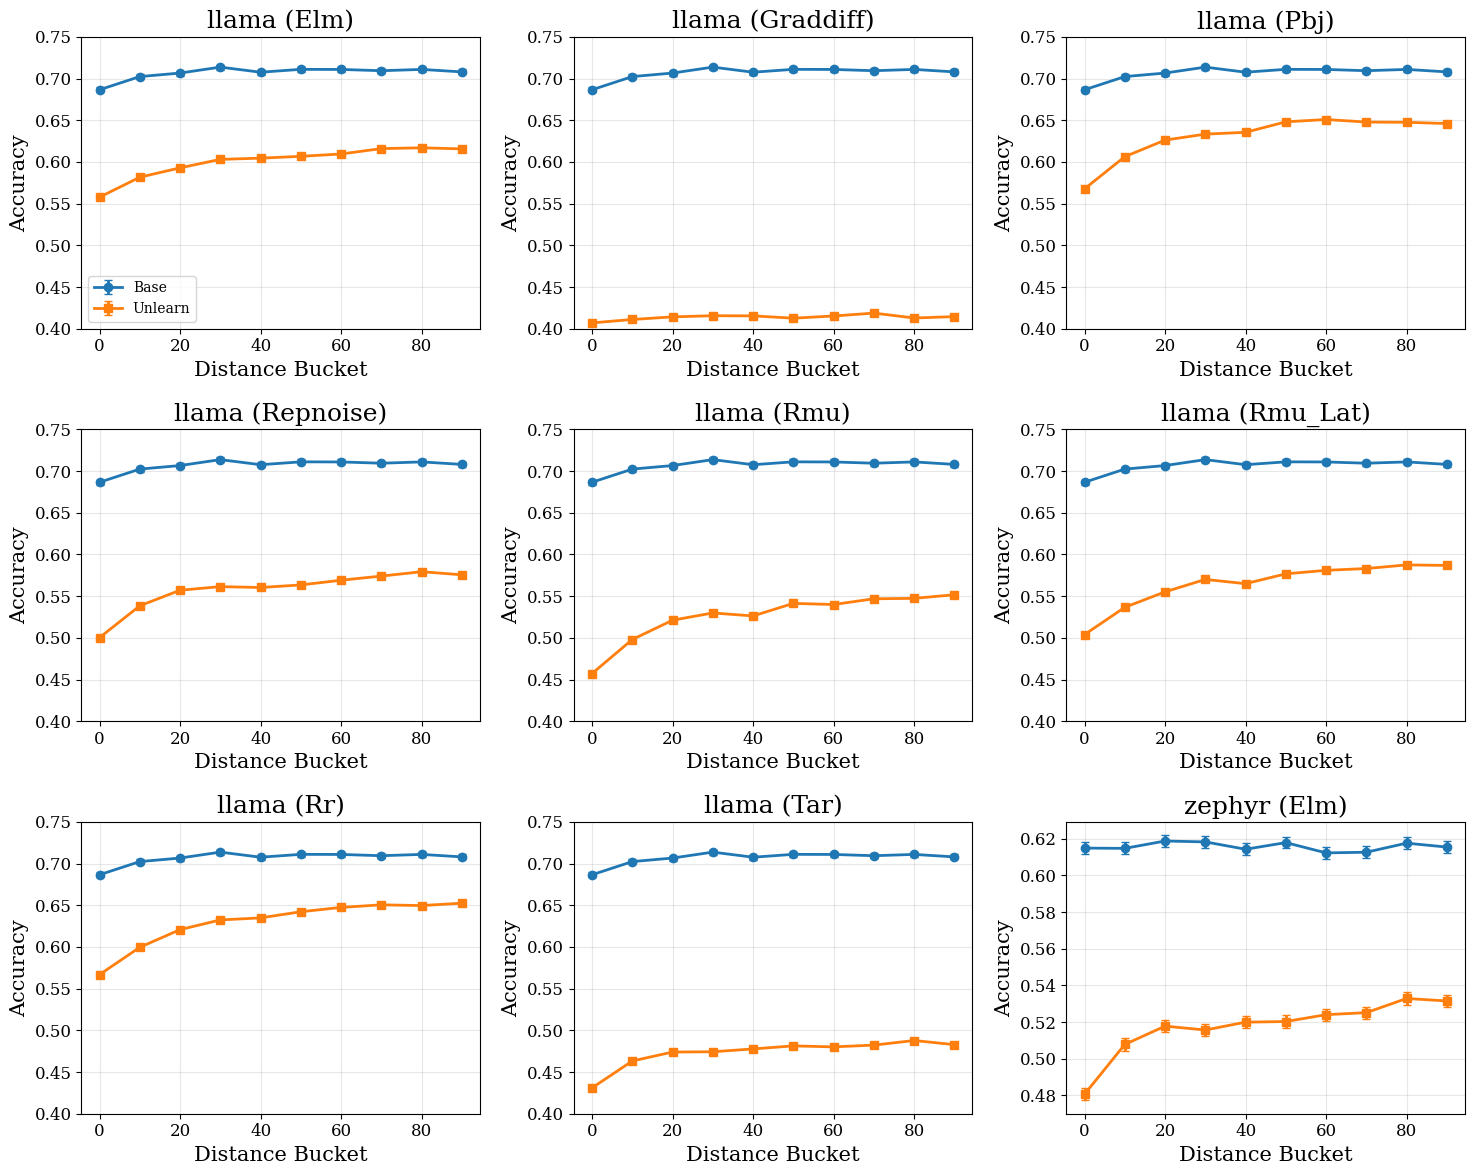

In [100]:
draw(results_fn=get_legacy_results)

In [101]:
def draw_delta(results_fn):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    i=0
    for model in UNLEARNING_RESULTS:
        base_df = load_df(BASE_RESULTS[model])
        base_results = results_fn(base_df)

        for method in UNLEARNING_RESULTS[model]:
            ax = axes[i]
            i+=1
            
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Calculate the difference between base and unlearn results
            difference = base_results["mean"] - unlearn_results_method["mean"]
            
            # Calculate error propagation for the difference
            # For independent measurements: σ(A-B) = sqrt(σ_A² + σ_B²)
            error_propagated = (base_results["sem"]**2 + unlearn_results_method["sem"]**2)**0.5
            
            # Plot the difference
            ax.errorbar(
                base_results.index,
                difference,
                yerr=error_propagated,
                marker="o",
                linewidth=2,
                markersize=6,
                capsize=3,
                label="Base - Unlearn",
            )
            
            ax.set_xlabel("Distance Bucket")
            ax.set_ylabel("Accuracy delta")
            ax.set_title(f"{model} ({method.title()})")
            if i == 1:
                ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            # if model == "llama":
            #     ax.set_ylim(0.4, 0.75)

    plt.tight_layout()
    plt.show()


def draw_combined(results_fn=get_legacy_results):
    """Draw base Llama model and all unlearned models on a single plot with legend."""
    
    from datetime import datetime
    
    # Define plot directory
    PLOT_DIR = Path("plots")
    PLOT_DIR.mkdir(exist_ok=True)
    
    # Method colors - consistent across base models
    METHOD_COLORS = {
        'elm': '#FF6B6B',      # Red
        'rmu': '#4ECDC4',      # Teal
        'graddiff': '#95E77E', # Light green
        'pbj': '#FFD93D',      # Yellow
        'tar': '#A8E6CF',      # Mint
        'rmu_lat': '#FF8B94',  # Pink
        'repnoise': '#B4A7D6', # Lavender
        'rr': '#FFB347'        # Orange
    }
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot base Llama model
    base_df = load_df(BASE_RESULTS["llama"])
    base_results = results_fn(base_df)
    
    ax.errorbar(
        base_results.index,
        base_results["mean"] * 100,  # Convert to percentage
        yerr=base_results["sem"] * 100,  # Convert to percentage
        marker='o',
        linewidth=3,
        markersize=7,
        capsize=3,
        linestyle='-',
        color='black',
        alpha=0.9,
        label="Llama3 Base",
        zorder=10  # Put base on top
    )
    
    # Process each unlearned model
    for model in UNLEARNING_RESULTS:
        # Set line style based on base model
        if model == "zephyr":
            linestyle = '--'  # Dashed for Zephyr
            marker = '^'      # Triangle for Zephyr
            prefix = "Zephyr-"
            alpha = 0.7
        else:  # llama
            linestyle = '-'   # Solid for Llama
            marker = 's'      # Square for Llama  
            prefix = "Llama3-"
            alpha = 0.8
        
        for method in UNLEARNING_RESULTS[model]:
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Get color for this method
            color = METHOD_COLORS.get(method, '#888888')
            
            # Plot the unlearned model accuracy
            ax.errorbar(
                unlearn_results_method.index,
                unlearn_results_method["mean"] * 100,  # Convert to percentage
                yerr=unlearn_results_method["sem"] * 100,  # Convert to percentage
                marker=marker,
                linewidth=2,
                markersize=5,
                capsize=2,
                linestyle=linestyle,
                color=color,
                alpha=alpha,
                label=f"{prefix}{method.upper().replace('_', '-')}",
            )
    
    ax.set_xlabel("Distance Bucket", fontsize=14)
    ax.set_ylabel("Accuracy (%)", fontsize=14)
    ax.set_title("Ripple Effects: Base vs Unlearned Models", fontsize=16)
    ax.legend(loc="lower right", ncol=2, fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(40, 75)  # Update y-axis limits to percentage scale
    
    plt.tight_layout()
    
    # Save the plot
    date_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    fn = f"ripple_effects_base_vs_unlearned_full_{results_fn.__name__}_{date_str}"
    plt.savefig(PLOT_DIR / f"{fn}.png")
    plt.savefig(PLOT_DIR / f"{fn}.pdf")
    
    plt.show()
    
    # Also create a focused view (0-30)
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    
    # Plot base Llama model (focused)
    base_results_filtered = base_results[base_results.index <= 30]
    
    ax2.errorbar(
        base_results_filtered.index,
        base_results_filtered["mean"] * 100,  # Convert to percentage
        yerr=base_results_filtered["sem"] * 100,  # Convert to percentage
        marker='o',
        linewidth=3,
        markersize=8,
        capsize=3,
        linestyle='-',
        color='black',
        alpha=0.9,
        label="Llama3 Base",
        zorder=10  # Put base on top
    )
    
    # Process each unlearned model (focused view)
    for model in UNLEARNING_RESULTS:
        # Set line style based on base model
        if model == "zephyr":
            linestyle = '--'  # Dashed for Zephyr
            marker = '^'      # Triangle for Zephyr
            prefix = "Zephyr-"
            alpha = 0.7
        else:  # llama
            linestyle = '-'   # Solid for Llama
            marker = 's'      # Square for Llama  
            prefix = "Llama3-"
            alpha = 0.8
        
        for method in UNLEARNING_RESULTS[model]:
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Filter to only show 0-30
            unlearn_results_filtered = unlearn_results_method[unlearn_results_method.index <= 30]
            
            # Get color for this method
            color = METHOD_COLORS.get(method, '#888888')
            
            # Plot the unlearned model accuracy
            ax2.errorbar(
                unlearn_results_filtered.index,
                unlearn_results_filtered["mean"] * 100,  # Convert to percentage
                yerr=unlearn_results_filtered["sem"] * 100,  # Convert to percentage
                marker=marker,
                linewidth=2.5,
                markersize=6,
                capsize=3,
                linestyle=linestyle,
                color=color,
                alpha=alpha,
                label=f"{prefix}{method.upper().replace('_', '-')}",
            )
    
    ax2.set_xlabel("Distance Bucket", fontsize=14)
    ax2.set_ylabel("Accuracy (%)", fontsize=14)
    ax2.set_title("Ripple Effects: Focused View (Distance 0-30)", fontsize=16)
    ax2.legend(loc="lower right", ncol=2, fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-2, 32)
    ax2.set_ylim(40, 75)  # Update y-axis limits to percentage scale
    
    plt.tight_layout()
    
    # Save the focused plot
    fn_focused = f"ripple_effects_base_vs_unlearned_focused_{results_fn.__name__}_{date_str}"
    plt.savefig(PLOT_DIR / f"{fn_focused}.png")
    plt.savefig(PLOT_DIR / f"{fn_focused}.pdf")
    
    plt.show()

Now, let's look at loss delta. The data is the same, just a different way to plot the same accuracies.

We see pretty much the same picture: with deduplicated questions there's a big drop until distance 20. From then on the delta still goes down with distance, but much slower.

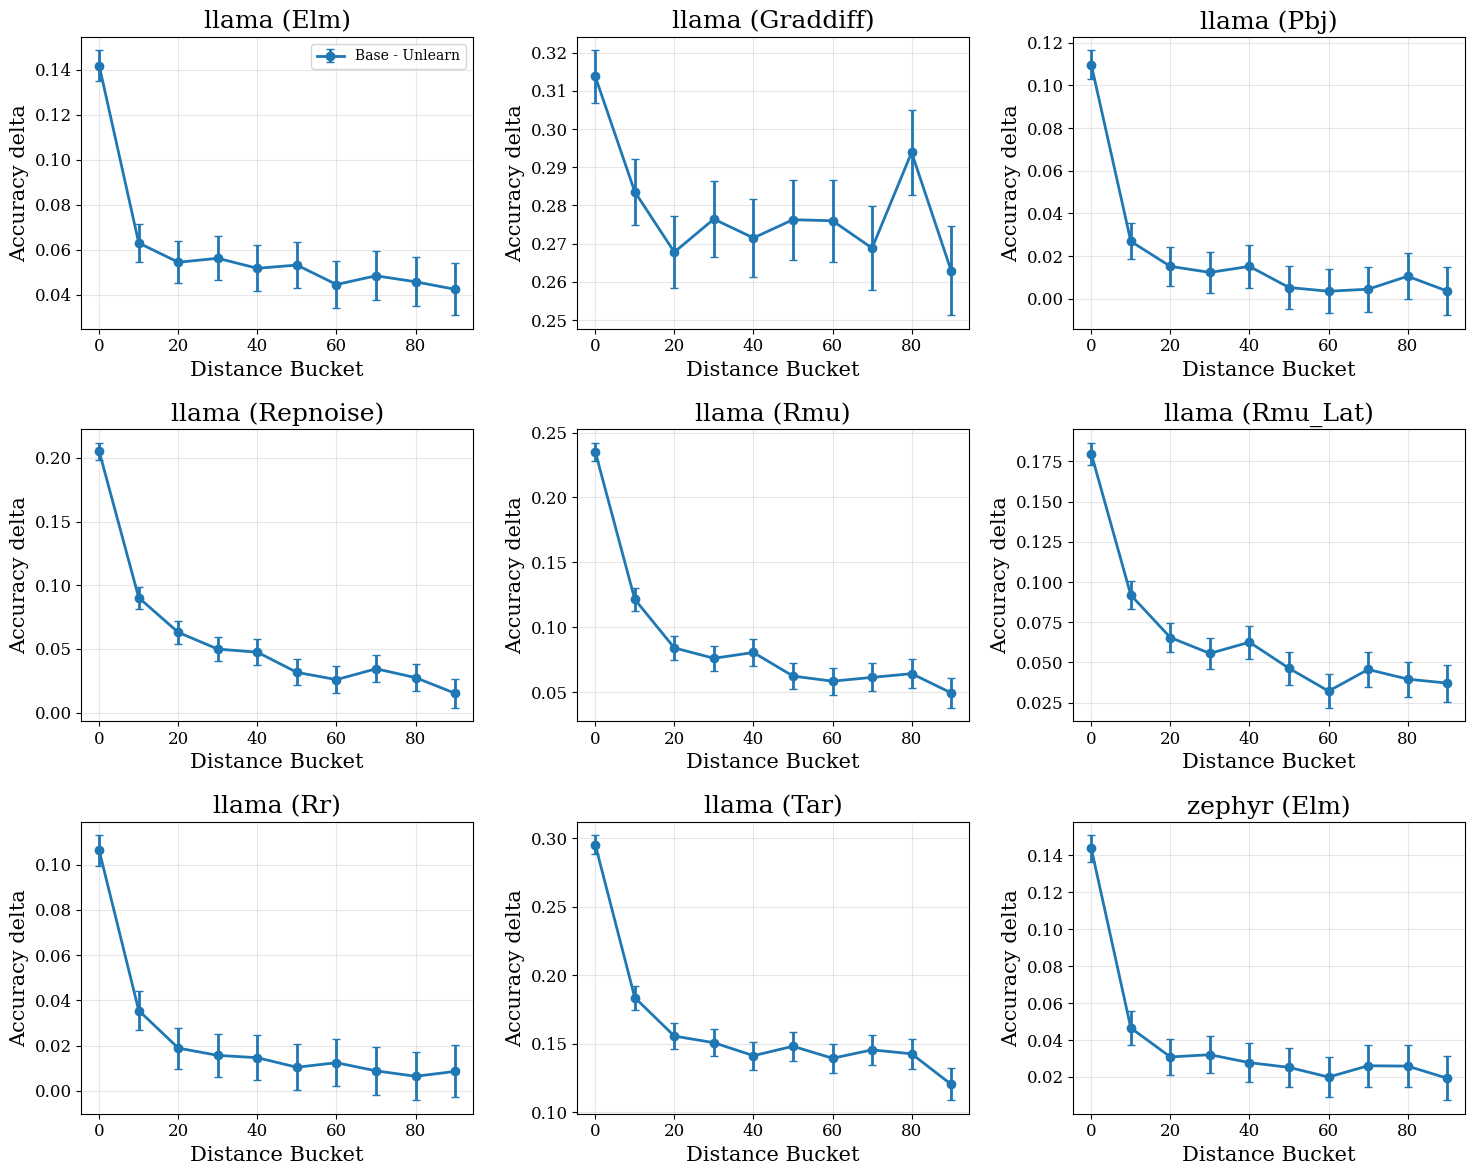

In [102]:
draw_delta(get_dedup_results)

And similar thing with non-deduplicated dataset. 0-20 drop is not as drastic here, otherwise the numbers gradually go down with distance. Note that Y-axis is different there, so the slow drop is more pronounced.

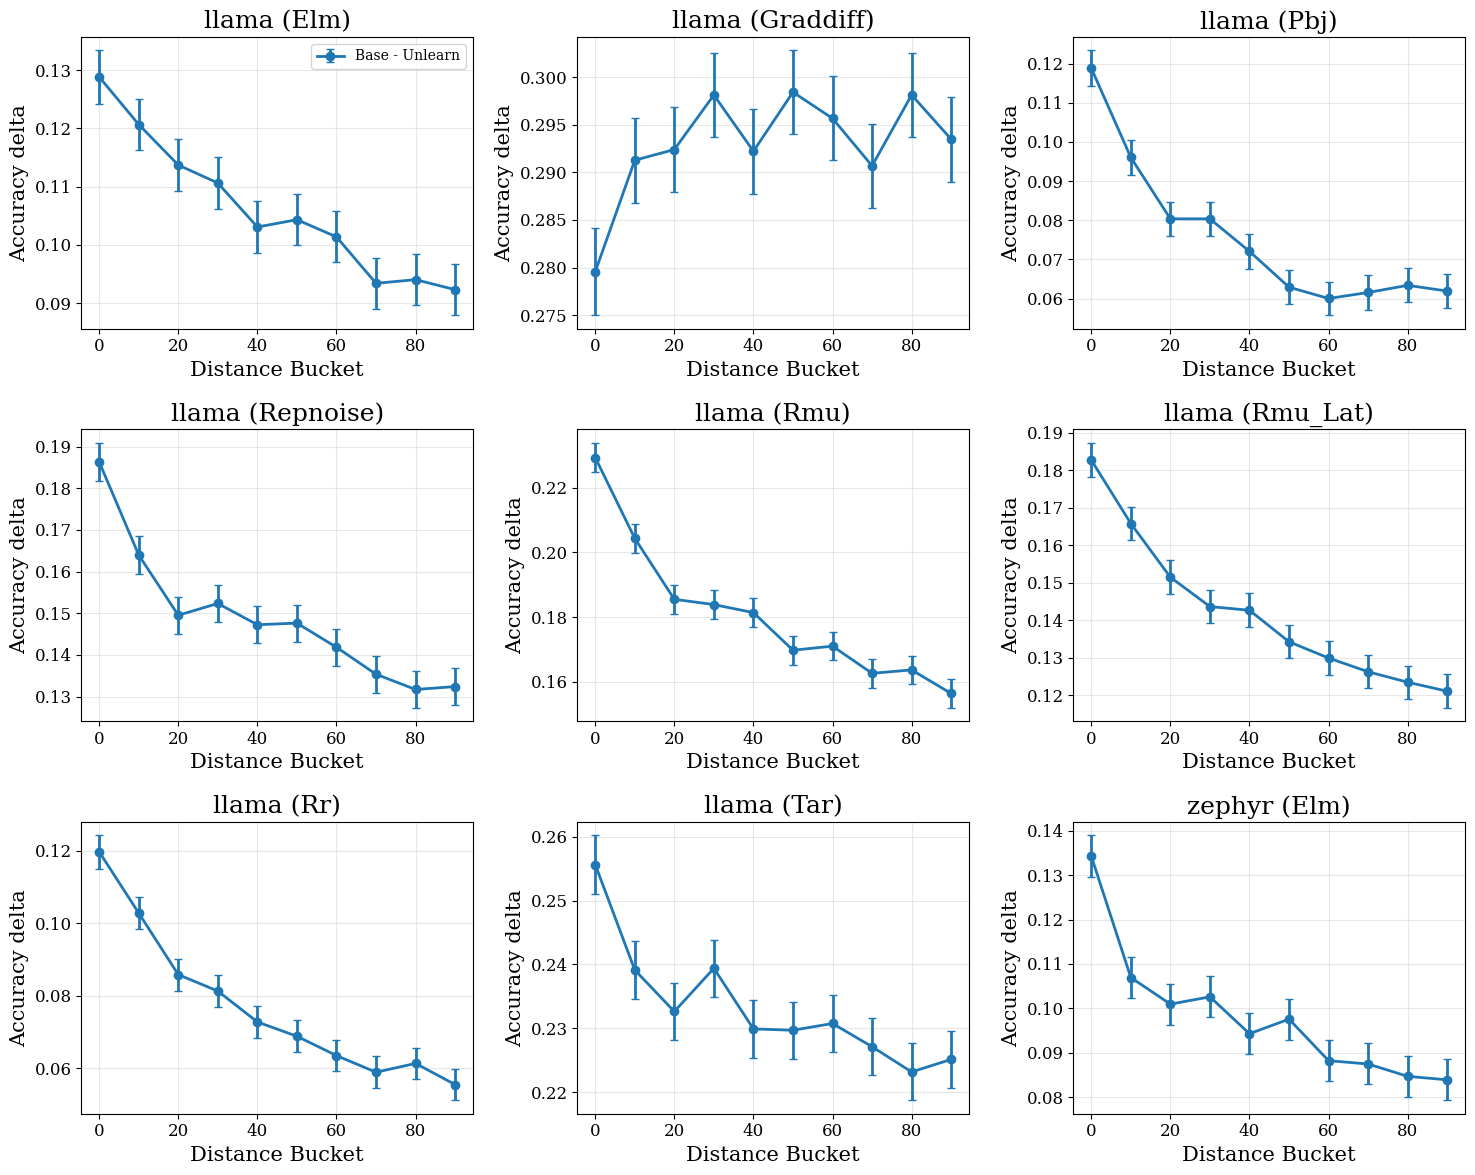

In [103]:
draw_delta(get_legacy_results)

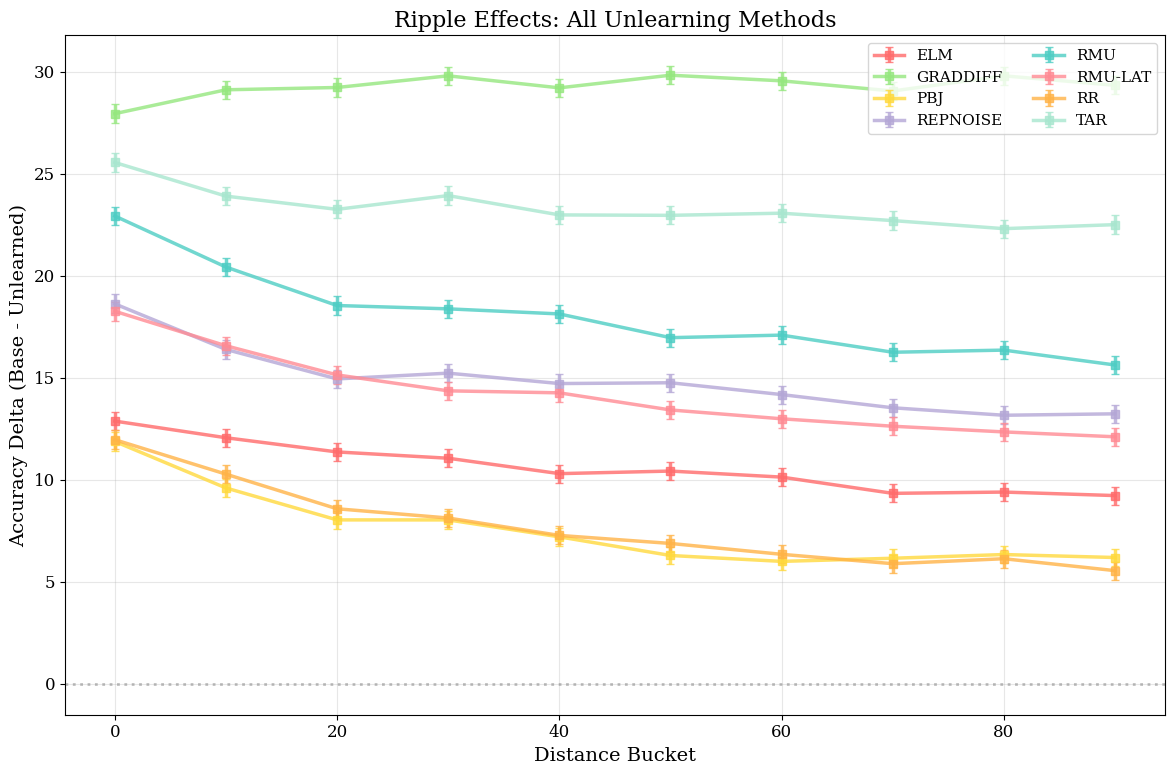

In [104]:
def draw_delta(results_fn):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    i=0
    for model in UNLEARNING_RESULTS:
        base_df = load_df(BASE_RESULTS[model])
        base_results = results_fn(base_df)

        for method in UNLEARNING_RESULTS[model]:
            ax = axes[i]
            i+=1
            
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Calculate the difference between base and unlearn results
            difference = base_results["mean"] - unlearn_results_method["mean"]
            
            # Calculate error propagation for the difference
            # For independent measurements: σ(A-B) = sqrt(σ_A² + σ_B²)
            error_propagated = (base_results["sem"]**2 + unlearn_results_method["sem"]**2)**0.5
            
            # Plot the difference
            ax.errorbar(
                base_results.index,
                difference,
                yerr=error_propagated,
                marker="o",
                linewidth=2,
                markersize=6,
                capsize=3,
                label="Base - Unlearn",
            )
            
            ax.set_xlabel("Distance Bucket")
            ax.set_ylabel("Accuracy delta")
            ax.set_title(f"{model} ({method.title()})")
            if i == 1:
                ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            # if model == "llama":
            #     ax.set_ylim(0.4, 0.75)

    plt.tight_layout()
    plt.show()


def draw_combined(results_fn=get_legacy_results):
    """Draw all models on a single plot with legend."""
    
    # Method colors - consistent across base models
    METHOD_COLORS = {
        'elm': '#FF6B6B',      # Red
        'rmu': '#4ECDC4',      # Teal
        'graddiff': '#95E77E', # Light green
        'pbj': '#FFD93D',      # Yellow
        'tar': '#A8E6CF',      # Mint
        'rmu_lat': '#FF8B94',  # Pink
        'repnoise': '#B4A7D6', # Lavender
        'rr': '#FFB347'        # Orange
    }
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Process each model
    for model in UNLEARNING_RESULTS:
        base_df = load_df(BASE_RESULTS[model])
        base_results = results_fn(base_df)
        
        # Set line style based on base model
        if model == "zephyr":
            linestyle = '--'  # Dashed for Zephyr
            marker = 'o'      # Circle for Zephyr
            prefix = "Zephyr-"
            continue
        else:  # llama
            linestyle = '-'   # Solid for Llama
            marker = 's'      # Square for Llama  
            prefix = "Llama3-"
            prefix = "" 
        
        for method in UNLEARNING_RESULTS[model]:
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Calculate the difference between base and unlearn results
            difference = base_results["mean"] - unlearn_results_method["mean"]
            
            # Calculate error propagation for the difference
            error_propagated = (base_results["sem"]**2 + unlearn_results_method["sem"]**2)**0.5
            
            # Get color for this method
            color = METHOD_COLORS.get(method, '#888888')
            
            # Plot the difference
            ax.errorbar(
                base_results.index,
                difference * 100,
                yerr=error_propagated * 100,
                marker=marker,
                linewidth=2.5,
                markersize=6,
                capsize=3,
                linestyle=linestyle,
                color=color,
                alpha=0.8,
                label=f"{prefix}{method.upper().replace('_', '-')}",
            )
    
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel("Distance Bucket", fontsize=14)
    ax.set_ylabel("Accuracy Delta (Base - Unlearned)", fontsize=14)
    ax.set_title("Ripple Effects: All Unlearning Methods", fontsize=16)
    ax.legend(loc="upper right", ncol=2, fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    date_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    fn = f"diff_ripple_effects_base_vs_unlearned_models_{results_fn.__name__}_{date_str}"
    plt.savefig(PLOT_DIR / f"{fn}.png")
    plt.savefig(PLOT_DIR / f"{fn}.pdf")
    plt.show()
    
    
    
draw_combined(results_fn=get_legacy_results)

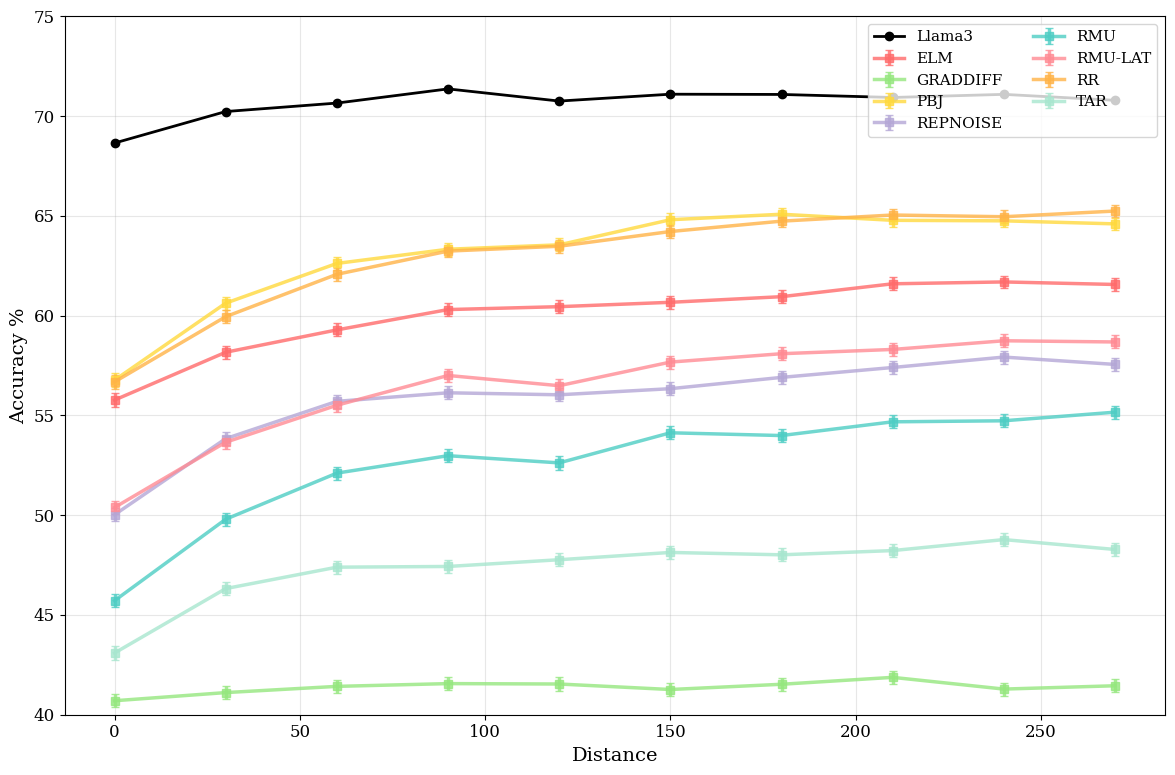

In [108]:


def draw_combined(results_fn=get_legacy_results):
    """Draw all models on a single plot with legend."""
    
    # Method colors - consistent across base models
    METHOD_COLORS = {
        'elm': '#FF6B6B',      # Red
        'rmu': '#4ECDC4',      # Teal
        'graddiff': '#95E77E', # Light green
        'pbj': '#FFD93D',      # Yellow
        'tar': '#A8E6CF',      # Mint
        'rmu_lat': '#FF8B94',  # Pink
        'repnoise': '#B4A7D6', # Lavender
        'rr': '#FFB347'        # Orange
    }
    
    fig, ax = plt.subplots(figsize=(12, 8))
    # plot the base model accuracy
    for model in BASE_RESULTS:
        if model == "llama":
            
            base_df = load_df(BASE_RESULTS[model])
            base_results = results_fn(base_df)
            ax.plot(base_results.index * 3, base_results["mean"] * 100, label="Llama3", linestyle="-", marker="o", color = "black")
            
            
    
    ax.legend()
    
    # Process each model
    for model in UNLEARNING_RESULTS:
        base_df = load_df(BASE_RESULTS[model])
        base_results = results_fn(base_df)
        
        # Set line style based on base model
        if model == "zephyr":
            linestyle = '--'  # Dashed for Zephyr
            marker = 'o'      # Circle for Zephyr
            prefix = "Zephyr-"
            continue
        else:  # llama
            linestyle = '-'   # Solid for Llama
            marker = 's'      # Square for Llama  
            prefix = "Llama3-"
            prefix = "" 
        
        for method in UNLEARNING_RESULTS[model]:
            # Load unlearning results for this method
            unlearn_df_method = load_df(UNLEARNING_RESULTS[model][method])
            unlearn_results_method = results_fn(unlearn_df_method)
            
            # Calculate the difference between base and unlearn results
            method_acc =  unlearn_results_method["mean"] * 100
            
            # Calculate error propagation for the difference
            error = unlearn_results_method["sem"] * 100
            # Get color for this method
            color = METHOD_COLORS.get(method, '#888888')
            
            # Plot the difference
            ax.errorbar(
                base_results.index * 3,
                method_acc ,
                yerr=error,
                marker=marker,
                linewidth=2.5,
                markersize=6,
                capsize=3,
                linestyle=linestyle,
                color=color,
                alpha=0.8,
                label=f"{prefix}{method.upper().replace('_', '-')}",
            )
    
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel("Distance", fontsize=14)
    ax.set_ylabel("Accuracy %", fontsize=14)
    
    #ax.set_title("Ripple Effects: All Unlearning Methods", fontsize=16)
    
    ax.legend(loc="upper right", ncol=2, fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.ylim(40, 75)
    
    plt.tight_layout()
    date_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    if True:
        fn = f"ripple_effects_base_vs_unlearned_models_{results_fn.__name__}_{date_str}"
        plt.savefig(PLOT_DIR / f"{fn}.png")
        plt.savefig(PLOT_DIR / f"{fn}.pdf")
    plt.show()
    
    
    
draw_combined(results_fn=get_legacy_results)